# Implementation of Colvolutional Neural Networks 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score, f1_score, precision_score
from sklearn.utils.class_weight import compute_class_weight

from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
%matplotlib inline

from prettytable import PrettyTable

In [5]:
 import nltk
 nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
device = torch.device("cuda")

In [ ]:
try: 
    os.chdir("/content/drive/MyDrive/Colab Notebooks")
    print("Directory changed")
except OSError:
    print("Error: Can't change the Current Working Directory")

Directory changed


In [7]:
# Define constants
EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 1e-5
SEED = 4222

In [8]:
suicide_detection_df = pd.read_csv('/content/drive/MyDrive/dataset/suicide_detection_final_cleaned.csv', header=0)
suicide_detection_df.drop(columns=['text'], axis=1, inplace=True)
suicide_detection_df = suicide_detection_df.rename(columns={"clean_msg": "text"})
classes = {"suicide": 1, "non-suicide": 0}
suicide_detection_df = suicide_detection_df.replace({"class": classes})
suicide_detection_df.head()

,Unnamed: 0,class,text
0,3,0,weird not get affected compliment coming someo...
1,4,0,finally almost never hear bad year ever swear ...
2,8,1,need help help cry hard
3,13,1,end tonight not anymore quit
4,19,1,took rest sleeping pill painkiller not wait en...


In [9]:
train_text, temp_text, train_labels, temp_labels = train_test_split(suicide_detection_df['text'], 
                                                                    suicide_detection_df['class'],
                                                                    random_state=SEED,
                                                                    test_size=0.2,
                                                                    stratify=suicide_detection_df['class'])

val_text , test_text , val_labels , test_labels = train_test_split(temp_text ,
                                                                   temp_labels,
                                                                   random_state=SEED,
                                                                   test_size=0.5,
                                                                   stratify=temp_labels)


In [10]:
max_length = max([len(s.split()) for s in train_text])
max_length


62

In [31]:
train_text.head()

23467     creepy account followed posted something someo...
129548    realize kill december recent past friend famil...
164329    love clipping hair bleached feel need trim sup...
118356    not want alive anymore alone bad person care m...
70396     deal someone lying caring not care not one car...
Name: text, dtype: object

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text)

vocab_size = len(tokenizer.word_index)+1

In [13]:
def tokenize_and_encode(text, max_length=62):
    encoded_docs = tokenizer.texts_to_sequences(text)
    padded_sequence = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

    return padded_sequence

# Tokenize and encode sequences in all datasets
tokens_train = tokenize_and_encode(train_text)
tokens_val = tokenize_and_encode(val_text)
tokens_test = tokenize_and_encode(test_text)


In [14]:
train_data = TensorDataset(torch.from_numpy(tokens_train), torch.from_numpy(train_labels.to_numpy()))
val_data = TensorDataset(torch.from_numpy(tokens_val), torch.from_numpy(val_labels.to_numpy()))

In [15]:
train_sampler = RandomSampler(train_data)
val_sampler = SequentialSampler(val_data)

## DataLoader

In [16]:

train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)

# Loading Word Embeddings 

In [47]:
from gensim.models import Word2Vec
import nltk
data=pd.read_csv('/content/drive/MyDrive/dataset/suicide_detection_final_cleaned.csv',encoding='utf-8')
data['tokens'] = data['clean_msg'].apply(lambda x:nltk.word_tokenize(x))
model = Word2Vec(data['tokens'], vector_size=300, min_count=1)
model.save("word2vec.model")
from gensim.models import KeyedVectors
model = KeyedVectors.load("word2vec.model", mmap='r')
model.wv['pass']

memmap([-0.0275037 ,  0.03092316,  0.01424963,  0.2104478 ,  0.18439096,
        -0.04258012, -0.05548488,  0.10089509,  0.07837665,  0.06487896,
        -0.2357744 ,  0.12273563, -0.0978692 ,  0.11383986,  0.1530465 ,
         0.032842  ,  0.15843906,  0.14329489, -0.15406004,  0.07535824,
        -0.08195169,  0.03957147,  0.02500191,  0.10166683, -0.25771976,
        -0.07971987,  0.17958254, -0.23498257, -0.01239769,  0.12835726,
         0.02848144,  0.03733095, -0.07698274, -0.08567388,  0.09311298,
         0.2328964 ,  0.0121145 , -0.11823147, -0.25353354,  0.24629658,
         0.04803937,  0.19718775,  0.14182425, -0.15369254,  0.04873293,
        -0.05590167,  0.13540776, -0.06769478,  0.0887337 , -0.186985  ,
         0.02893303, -0.41682333, -0.02093649, -0.21311167, -0.01076264,
         0.28085938, -0.05169273, -0.06253446, -0.22706705,  0.10982954,
         0.05274032, -0.0441177 ,  0.03290827, -0.05997289, -0.06060196,
        -0.12796316, -0.23463586,  0.47914138, -0.0

In [48]:
def load_embedding(model_path):
    """Load pre-trained Word2Vec embeddings from a Gensim model file.

    Args:
        model_path (str): Path to the Gensim Word2Vec model file.

    Returns:
        dict: A dictionary mapping each word to its corresponding embedding vector.
    """
    embedding_dict = {}
    model = KeyedVectors.load(model_path)

    for word in model.wv.key_to_index.keys():
        embedding_dict[word] = model.wv[word]
    
    return embedding_dict

In [49]:
def load_embedding_glove(filename):
	file = open(filename,'r')
	lines = file.readlines()[1:]
	file.close()
	embedding = dict()
	for line in lines:
		parts = line.split()
		embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
	return embedding

In [50]:
def get_weight_matrix(embedding, vocab, embedding_dim):
	vocab_size = len(vocab) + 1
	weight_matrix = np.zeros((vocab_size, embedding_dim))
	for word, i in vocab.items():
		weight_matrix[i] = embedding.get(word)

	return weight_matrix

In [51]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape[0], weights_matrix.shape[1]
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': torch.from_numpy(weights_matrix)})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

In [52]:
def get_text_vector(text):

    vector = np.zeros(300)
    count = 0
    for token in text:
        try:
            vector += model.wv[token]
            count += 1
        except KeyError:
            continue
    if count != 0:
        vector /= count
    return vector

data['text_vector'] = data['tokens'].apply(get_text_vector)

In [53]:
data.head()

,Unnamed: 0,text,class,clean_msg,tokens,text_vector
0,3,Am I weird I don't get affected by compliments...,non-suicide,weird not get affected compliment coming someo...,"[weird, not, get, affected, compliment, coming...","[0.7055002152919769, -0.04264983518182167, -0...."
1,4,Finally 2020 is almost over... So I can never ...,non-suicide,finally almost never hear bad year ever swear ...,"[finally, almost, never, hear, bad, year, ever...","[0.667242802340876, -0.25702551718462596, -0.3..."
2,8,i need helpjust help me im crying so hard,suicide,need help help cry hard,"[need, help, help, cry, hard]","[0.8219113126397133, 0.33248451287126957, -0.0..."
3,13,It ends tonight.I can’t do it anymore. \nI quit.,suicide,end tonight not anymore quit,"[end, tonight, not, anymore, quit]","[1.0425579726696015, 0.05171641409397125, -0.1..."
4,19,I took the rest of my sleeping pills and my pa...,suicide,took rest sleeping pill painkiller not wait en...,"[took, rest, sleeping, pill, painkiller, not, ...","[0.7345938748465135, 0.3454161842282002, 0.066..."


In [54]:
raw_embedding_word2vec = load_embedding('/content/drive/MyDrive/Colab Notebooks/word2vec.model')
# get vectors in the right order
embedding_vectors_word2vec = get_weight_matrix(raw_embedding_word2vec, tokenizer.word_index, 300)
embedding_vectors_word2vec = np.float32(embedding_vectors_word2vec)

In [61]:
raw_embedding_glove = load_embedding_glove('/content/drive/MyDrive/glove/glove.twitter.27B.200d.txt')
embedding_vectors_glove = get_weight_matrix(raw_embedding_glove, tokenizer.word_index, 200)
embedding_vectors_glove = np.float32(embedding_vectors_glove)

In [62]:
for arr in embedding_vectors_glove:
    for idx, i in enumerate(arr):
        if np.isnan(arr[idx]):
            arr[idx] = 0

# Lstm Architecture

In [69]:
class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, 
                 embedding_dim, hidden_dim, n_layers, 
                 dropout_rate, pre_trained=False, embedding_vectors=None):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        if pre_trained:
            self.embedding, num_embeddings, embedding_dim = create_emb_layer(embedding_vectors, True)
        else:
            # Create word embeddings from the input words
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=dropout_rate, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3) # dropout_rate
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        
        return hidden
        

In [40]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [41]:
# Instantiate the model w/ hyperparams
embedding_dim = 300
hidden_dim = 128
output_size = 1
n_layers = 2
dropout = 0.5

In [42]:
# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# push to GPU
criterion = criterion.to(device)

### Model 1:No pre trained embedding weights 

In [43]:
model1 = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout)

print("No pre trained embedding weights")
print(model1)
print(f'Model 1 has {count_parameters(model1):,} trainable parameters')

No pre trained embedding weights
SentimentLSTM(
  (embedding): Embedding(32372, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)
Model 1 has 10,063,985 trainable parameters


### Model 2:word2vec custom trained embedding weights

In [58]:
model2 = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout, 
                       pre_trained=True, embedding_vectors=embedding_vectors_word2vec)
model2.embedding.weight.data.copy_(torch.from_numpy(embedding_vectors_word2vec))

print("With Word2Vec pre trained embedding weights")
print(model2)
print(f'Model 2 has {count_parameters(model2):,} trainable parameters')

With Word2Vec pre trained embedding weights
SentimentLSTM(
  (embedding): Embedding(32372, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)
Model 2 has 352,385 trainable parameters


### glove Twitter dataset (200d) pre trained embedding weights 

In [63]:
model3 = SentimentLSTM(vocab_size, output_size, 200, hidden_dim, n_layers, dropout, 
                       pre_trained=True, embedding_vectors=embedding_vectors_glove)
model3.embedding.weight.data.copy_(torch.from_numpy(embedding_vectors_glove))

print("With gloVe pre trained embedding weights")
print(model3)
print(f'Model 3 has {count_parameters(model3):,} trainable parameters')

With gloVe pre trained embedding weights
SentimentLSTM(
  (embedding): Embedding(32372, 200)
  (lstm): LSTM(200, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)
Model 3 has 301,185 trainable parameters


# functions to Train and Evaluate the model 

In [64]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

In [71]:
# function to train the model
def train():

    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds = []

    # iterate over batches of train data
    for step, batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('Batch {:>5,} of {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        # batch = [r.to(device) for r in batch]

        inputs, labels = batch
        inputs = inputs.type(torch.LongTensor)

        # initialize hidden state
        h = model.init_hidden(len(inputs))

        # move to gpu
        inputs, labels = inputs.cuda(), labels.cuda()

        # Create new variables for the hidden state
        h = tuple([each.data for each in h])

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for current batch
        preds, h = model(inputs, h)
        
        # compute the loss between actual and predicted values
        loss = criterion(preds.squeeze(), labels.float())

        # add on to the total loss
        total_loss += loss.item()
        
        # backward pass to calculate the gradients
        loss.backward()

        # clip the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model.parameters(), 5.0)

        # compute accuracy
        acc = binary_accuracy(preds, labels)

        # add on to the total accuracy
        total_accuracy += acc.item()

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # compute the training acc of the epoch
    avg_acc = total_accuracy / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    # returns the loss, accuracy and predictions
    return avg_loss, avg_acc, total_preds

In [72]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers

    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('Batch {:>5,} of {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        # batch = [t.to(device) for t in batch]

        inputs, labels = batch
        inputs = inputs.type(torch.LongTensor)

        # initialize hidden state
        val_h = model.init_hidden(len(inputs))

        # move to gpu
        inputs, labels = inputs.cuda(), labels.cuda()

        # Create new variables for the hidden state
        val_h = tuple([each.data for each in val_h])

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds, val_h = model(inputs, val_h)

            # compute the validation loss between actual and predicted values
            loss = criterion(preds.squeeze(), labels.float())

            total_loss += loss.item()

            acc = binary_accuracy(preds, labels)

            total_accuracy += acc.item()
            
            preds = preds.detach().cpu().numpy()
            
            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # compute the validation acc of the epoch
    avg_acc = total_accuracy / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, avg_acc, total_preds

## Model 1: No pre trained embedding weights

In [67]:
# define the optimizer
optimizer = optim.Adam(model1.parameters(), lr=LEARNING_RATE)

# push to GPU
model = model1.to(device)

MODEL_WEIGHTS_PATH = 'model'

In [73]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
model1_train_losses = []
model1_valid_losses = []

# empty lists to store training and validation acc of each epoch
model1_train_accuracies = []
model1_valid_accuracies = []

# for each epoch
for epoch in range(EPOCHS):

    print('\n Epoch {:} / {:}'.format(epoch+1, EPOCHS))
    
    # train model
    train_loss, train_acc, _ = train()

    # evaluate model
    valid_loss, valid_acc, _ = evaluate()

    # save best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
    
    # append training and validation loss
    model1_train_losses.append(train_loss)
    model1_valid_losses.append(valid_loss)

    # append training and validation acc
    model1_train_accuracies.append(train_acc)
    model1_valid_accuracies.append(valid_acc)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    print(f'\nTraining Accuracy: {train_acc:.3f}')
    print(f'Validation Accuracy: {valid_acc:.3f}')


 Epoch 1 / 5
Batch    50 of 4,129.
Batch   100 of 4,129.
Batch   150 of 4,129.
Batch   200 of 4,129.
Batch   250 of 4,129.
Batch   300 of 4,129.
Batch   350 of 4,129.
Batch   400 of 4,129.
Batch   450 of 4,129.
Batch   500 of 4,129.
Batch   550 of 4,129.
Batch   600 of 4,129.
Batch   650 of 4,129.
Batch   700 of 4,129.
Batch   750 of 4,129.
Batch   800 of 4,129.
Batch   850 of 4,129.
Batch   900 of 4,129.
Batch   950 of 4,129.
Batch 1,000 of 4,129.
Batch 1,050 of 4,129.
Batch 1,100 of 4,129.
Batch 1,150 of 4,129.
Batch 1,200 of 4,129.
Batch 1,250 of 4,129.
Batch 1,300 of 4,129.
Batch 1,350 of 4,129.
Batch 1,400 of 4,129.
Batch 1,450 of 4,129.
Batch 1,500 of 4,129.
Batch 1,550 of 4,129.
Batch 1,600 of 4,129.
Batch 1,650 of 4,129.
Batch 1,700 of 4,129.
Batch 1,750 of 4,129.
Batch 1,800 of 4,129.
Batch 1,850 of 4,129.
Batch 1,900 of 4,129.
Batch 1,950 of 4,129.
Batch 2,000 of 4,129.
Batch 2,050 of 4,129.
Batch 2,100 of 4,129.
Batch 2,150 of 4,129.
Batch 2,200 of 4,129.
Batch 2,250 of 4,1

In [74]:
# load weights of best model cnn
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

<All keys matched successfully>

## Run trained model 1 on Test dataset

In [75]:
# create Tensor datasets
test_data = TensorDataset(torch.from_numpy(tokens_test), torch.from_numpy(test_labels.to_numpy()))

# Sampler for sampling the data
test_sampler = SequentialSampler(test_data)

# DataLoader
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [76]:
# empty list to save the model predictions
total_preds = []

# iterate over batches
for step, batch in enumerate(test_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
        print('Batch {:>5,} of {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu
    # batch = [t.to(device) for t in batch]

    inputs, labels = batch
    inputs = inputs.type(torch.LongTensor)

    # initialize hidden state
    test_h = model.init_hidden(len(inputs)) # BATCH_SIZE # to discuss!!!!!!!!!

    # move to gpu
    inputs, labels = inputs.cuda(), labels.cuda()

    # Create new variables for the hidden state
    test_h = tuple([each.data for each in test_h])

    # deactivate autograd
    with torch.no_grad():

        # model predictions
        preds, test_h = model(inputs, test_h)

        # convert output probabilities to predicted class (0 or 1)
        preds = torch.round(preds.squeeze())  # rounds to the nearest integer

        preds = preds.detach().cpu().numpy()

        total_preds.append(preds)

# reshape the predictions in form of (number of samples, no. of classes)
total_preds = np.concatenate(total_preds, axis=0)

Batch    50 of   517.
Batch   100 of   517.
Batch   150 of   517.
Batch   200 of   517.
Batch   250 of   517.
Batch   300 of   517.
Batch   350 of   517.
Batch   400 of   517.
Batch   450 of   517.
Batch   500 of   517.


## Model 1 Summary

In [77]:
print(classification_report(test_labels, total_preds, digits=4))

              precision    recall  f1-score   support

           0     0.8808    0.9340    0.9066     10520
           1     0.8705    0.7781    0.8217      5994

    accuracy                         0.8774     16514
   macro avg     0.8756    0.8561    0.8642     16514
weighted avg     0.8770    0.8774    0.8758     16514



In [78]:
model_1_test_accuracy_score = accuracy_score(test_labels, total_preds)
model_1_test_precision_score = precision_score(test_labels, total_preds)
model_1_test_recall_score = recall_score(test_labels, total_preds)
model_1_test_f1_score = f1_score(test_labels, total_preds)

# Model 2: Word2Vec pre trained embedding weights

In [79]:
# define the optimizer
optimizer = torch.optim.Adam(model2.parameters(), lr=LEARNING_RATE)

# push to GPU
model = model2.to(device)

MODEL_WEIGHTS_PATH = 'model2'

 ## Train and Evaluate Model 2

In [80]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
model2_train_losses = []
model2_valid_losses = []

# empty lists to store training and validation acc of each epoch
model2_train_accuracies = []
model2_valid_accuracies = []

# for each epoch
for epoch in range(EPOCHS):

    print('\n Epoch {:} / {:}'.format(epoch+1, EPOCHS))
    
    # train model
    train_loss, train_acc, _ = train()

    # evaluate model
    valid_loss, valid_acc, _ = evaluate()

    # save best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
    
    # append training and validation loss
    model2_train_losses.append(train_loss)
    model2_valid_losses.append(valid_loss)

    # append training and validation acc
    model2_train_accuracies.append(train_acc)
    model2_valid_accuracies.append(valid_acc)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    print(f'\nTraining Accuracy: {train_acc:.3f}')
    print(f'Validation Accuracy: {valid_acc:.3f}')


 Epoch 1 / 5
Batch    50 of 4,129.
Batch   100 of 4,129.
Batch   150 of 4,129.
Batch   200 of 4,129.
Batch   250 of 4,129.
Batch   300 of 4,129.
Batch   350 of 4,129.
Batch   400 of 4,129.
Batch   450 of 4,129.
Batch   500 of 4,129.
Batch   550 of 4,129.
Batch   600 of 4,129.
Batch   650 of 4,129.
Batch   700 of 4,129.
Batch   750 of 4,129.
Batch   800 of 4,129.
Batch   850 of 4,129.
Batch   900 of 4,129.
Batch   950 of 4,129.
Batch 1,000 of 4,129.
Batch 1,050 of 4,129.
Batch 1,100 of 4,129.
Batch 1,150 of 4,129.
Batch 1,200 of 4,129.
Batch 1,250 of 4,129.
Batch 1,300 of 4,129.
Batch 1,350 of 4,129.
Batch 1,400 of 4,129.
Batch 1,450 of 4,129.
Batch 1,500 of 4,129.
Batch 1,550 of 4,129.
Batch 1,600 of 4,129.
Batch 1,650 of 4,129.
Batch 1,700 of 4,129.
Batch 1,750 of 4,129.
Batch 1,800 of 4,129.
Batch 1,850 of 4,129.
Batch 1,900 of 4,129.
Batch 1,950 of 4,129.
Batch 2,000 of 4,129.
Batch 2,050 of 4,129.
Batch 2,100 of 4,129.
Batch 2,150 of 4,129.
Batch 2,200 of 4,129.
Batch 2,250 of 4,1

In [81]:
# load weights of best model lstm
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

<All keys matched successfully>

## Run trained model 2 on Test dataset

In [82]:
# create Tensor datasets
test_data = TensorDataset(torch.from_numpy(tokens_test), torch.from_numpy(test_labels.to_numpy()))

# Sampler for sampling the data
test_sampler = SequentialSampler(test_data)

# DataLoader
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [83]:
# empty list to save the model predictions
total_preds = []

# iterate over batches
for step, batch in enumerate(test_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
        print('Batch {:>5,} of {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu
    # batch = [t.to(device) for t in batch]

    inputs, labels = batch
    inputs = inputs.type(torch.LongTensor)

    # initialize hidden state
    test_h = model.init_hidden(len(inputs)) # BATCH_SIZE # to discuss!!!!!!!!!

    # move to gpu
    inputs, labels = inputs.cuda(), labels.cuda()

    # Create new variables for the hidden state
    test_h = tuple([each.data for each in test_h])

    # deactivate autograd
    with torch.no_grad():

        # model predictions
        preds, test_h = model(inputs, test_h)

        # convert output probabilities to predicted class (0 or 1)
        preds = torch.round(preds.squeeze())  # rounds to the nearest integer

        preds = preds.detach().cpu().numpy()

        total_preds.append(preds)

# reshape the predictions in form of (number of samples, no. of classes)
total_preds = np.concatenate(total_preds, axis=0)

Batch    50 of   517.
Batch   100 of   517.
Batch   150 of   517.
Batch   200 of   517.
Batch   250 of   517.
Batch   300 of   517.
Batch   350 of   517.
Batch   400 of   517.
Batch   450 of   517.
Batch   500 of   517.


## Model 2 Summary

In [84]:
print(classification_report(test_labels, total_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9180    0.9498    0.9337     10520
           1     0.9062    0.8512    0.8778      5994

    accuracy                         0.9140     16514
   macro avg     0.9121    0.9005    0.9057     16514
weighted avg     0.9138    0.9140    0.9134     16514



In [85]:
model_2_test_accuracy_score = accuracy_score(test_labels, total_preds)
model_2_test_precision_score = precision_score(test_labels, total_preds)
model_2_test_recall_score = recall_score(test_labels, total_preds)
model_2_test_f1_score = f1_score(test_labels, total_preds)

## Model 3: gloVe Twitter dataset (200d) pre trained embedding weights

In [86]:
# define the optimizer
optimizer = optim.Adam(model3.parameters(), lr=LEARNING_RATE)

# push to GPU
model = model3.to(device)

MODEL_WEIGHTS_PATH = 'model3'

### Train and Evaluate Model 3

In [87]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
model3_train_losses = []
model3_valid_losses = []

# empty lists to store training and validation acc of each epoch
model3_train_accuracies = []
model3_valid_accuracies = []

# for each epoch
for epoch in range(EPOCHS):

    print('\n Epoch {:} / {:}'.format(epoch+1, EPOCHS))
    
    # train model
    train_loss, train_acc, _ = train()

    # evaluate model
    valid_loss, valid_acc, _ = evaluate()

    # save best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
    
    # append training and validation loss
    model3_train_losses.append(train_loss)
    model3_valid_losses.append(valid_loss)

    # append training and validation acc
    model3_train_accuracies.append(train_acc)
    model3_valid_accuracies.append(valid_acc)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    print(f'\nTraining Accuracy: {train_acc:.3f}')
    print(f'Validation Accuracy: {valid_acc:.3f}')


 Epoch 1 / 5
Batch    50 of 4,129.
Batch   100 of 4,129.
Batch   150 of 4,129.
Batch   200 of 4,129.
Batch   250 of 4,129.
Batch   300 of 4,129.
Batch   350 of 4,129.
Batch   400 of 4,129.
Batch   450 of 4,129.
Batch   500 of 4,129.
Batch   550 of 4,129.
Batch   600 of 4,129.
Batch   650 of 4,129.
Batch   700 of 4,129.
Batch   750 of 4,129.
Batch   800 of 4,129.
Batch   850 of 4,129.
Batch   900 of 4,129.
Batch   950 of 4,129.
Batch 1,000 of 4,129.
Batch 1,050 of 4,129.
Batch 1,100 of 4,129.
Batch 1,150 of 4,129.
Batch 1,200 of 4,129.
Batch 1,250 of 4,129.
Batch 1,300 of 4,129.
Batch 1,350 of 4,129.
Batch 1,400 of 4,129.
Batch 1,450 of 4,129.
Batch 1,500 of 4,129.
Batch 1,550 of 4,129.
Batch 1,600 of 4,129.
Batch 1,650 of 4,129.
Batch 1,700 of 4,129.
Batch 1,750 of 4,129.
Batch 1,800 of 4,129.
Batch 1,850 of 4,129.
Batch 1,900 of 4,129.
Batch 1,950 of 4,129.
Batch 2,000 of 4,129.
Batch 2,050 of 4,129.
Batch 2,100 of 4,129.
Batch 2,150 of 4,129.
Batch 2,200 of 4,129.
Batch 2,250 of 4,1

In [88]:
# load weights of best model lstm
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

<All keys matched successfully>

## Run trained model 3 on Test dataset

In [89]:
# create Tensor datasets
test_data = TensorDataset(torch.from_numpy(tokens_test), torch.from_numpy(test_labels.to_numpy()))

# Sampler for sampling the data
test_sampler = SequentialSampler(test_data)

# DataLoader
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [90]:
# empty list to save the model predictions
total_preds = []

# iterate over batches
for step, batch in enumerate(test_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
        print('Batch {:>5,} of {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu
    # batch = [t.to(device) for t in batch]

    inputs, labels = batch
    inputs = inputs.type(torch.LongTensor)

    # initialize hidden state
    test_h = model.init_hidden(len(inputs)) # BATCH_SIZE # to discuss!!!!!!!!!

    # move to gpu
    inputs, labels = inputs.cuda(), labels.cuda()

    # Create new variables for the hidden state
    test_h = tuple([each.data for each in test_h])

    # deactivate autograd
    with torch.no_grad():

        # model predictions
        preds, test_h = model(inputs, test_h)

        # convert output probabilities to predicted class (0 or 1)
        preds = torch.round(preds.squeeze())  # rounds to the nearest integer

        preds = preds.detach().cpu().numpy()

        total_preds.append(preds)

# reshape the predictions in form of (number of samples, no. of classes)
total_preds = np.concatenate(total_preds, axis=0)

Batch    50 of   517.
Batch   100 of   517.
Batch   150 of   517.
Batch   200 of   517.
Batch   250 of   517.
Batch   300 of   517.
Batch   350 of   517.
Batch   400 of   517.
Batch   450 of   517.
Batch   500 of   517.


### Model 3 Summary

In [91]:
print(classification_report(test_labels, total_preds, digits=4))

              precision    recall  f1-score   support

           0     0.8773    0.9425    0.9087     10520
           1     0.8839    0.7686    0.8222      5994

    accuracy                         0.8794     16514
   macro avg     0.8806    0.8555    0.8655     16514
weighted avg     0.8797    0.8794    0.8773     16514



In [92]:
model_3_test_accuracy_score = accuracy_score(test_labels, total_preds)
model_3_test_precision_score = precision_score(test_labels, total_preds)
model_3_test_recall_score = recall_score(test_labels, total_preds)
model_3_test_f1_score = f1_score(test_labels, total_preds)

## Comparison across 3 models

In [95]:
table = PrettyTable()
table.field_names = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']

table.add_row(['LSTM without pre trained embedding weights', 
               format(model_1_test_accuracy_score, '.4f'), 
               format(model_1_test_precision_score, '.4f'), 
               format(model_1_test_recall_score, '.4f'), 
               format(model_1_test_f1_score, '.4f')])

table.add_row(['LSTM with Word2Vec pre trained embedding weights', 
               format(model_2_test_accuracy_score, '.4f'), 
               format(model_2_test_precision_score, '.4f'), 
               format(model_2_test_recall_score, '.4f'), 
               format(model_2_test_f1_score, '.4f')])

table.add_row(['LSTM with gloVe Twitter (200d) pre trained embedding weights', 
               format(model_3_test_accuracy_score, '.4f'), 
               format(model_3_test_precision_score, '.4f'), 
               format(model_3_test_recall_score, '.4f'), 
               format(model_3_test_f1_score, '.4f')])
print(table)

+--------------------------------------------------------------+----------+-----------+--------+----------+
|                            Model                             | Accuracy | Precision | Recall | F1 Score |
+--------------------------------------------------------------+----------+-----------+--------+----------+
|          LSTM without pre trained embedding weights          |  0.8774  |   0.8705  | 0.7781 |  0.8217  |
|       LSTM with Word2Vec pre trained embedding weights       |  0.9140  |   0.9062  | 0.8512 |  0.8778  |
| LSTM with gloVe Twitter (200d) pre trained embedding weights |  0.8794  |   0.8839  | 0.7686 |  0.8222  |
+--------------------------------------------------------------+----------+-----------+--------+----------+


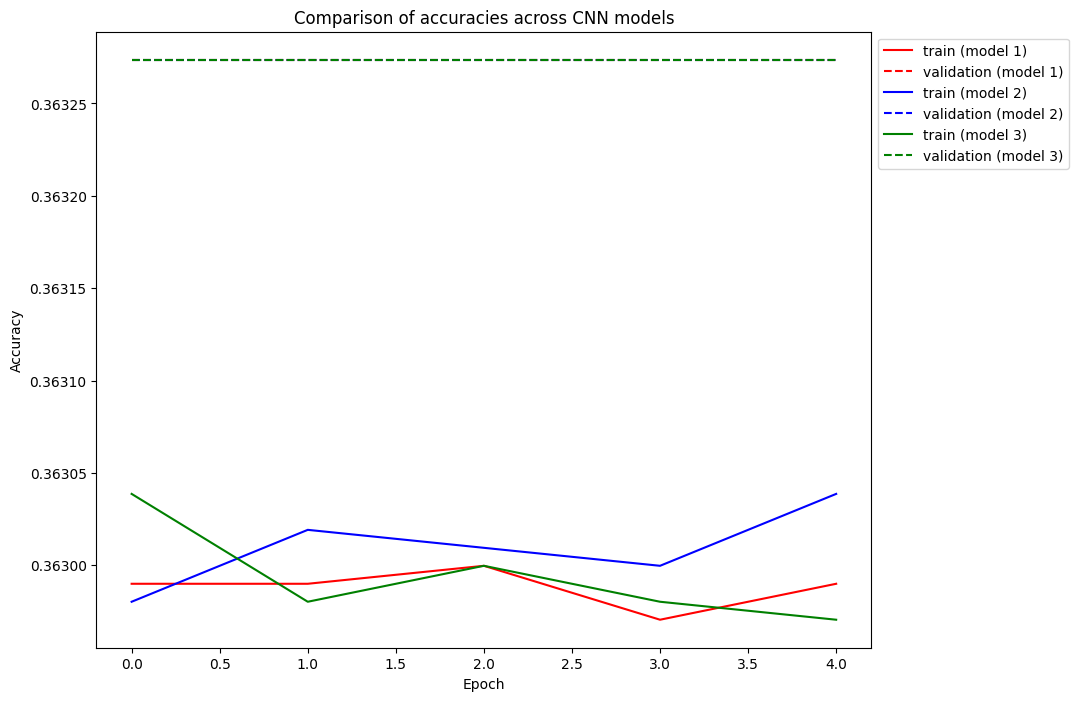

In [96]:
# summarize history for accuracy
plt.figure(figsize=(10,8))
plt.plot(model1_train_accuracies, "r-")
plt.plot(model1_valid_accuracies, "r--")
plt.plot(model2_train_accuracies, "b-")
plt.plot(model2_valid_accuracies, "b--")
plt.plot(model3_train_accuracies, "g-")
plt.plot(model3_valid_accuracies, "g--")
plt.title('Comparison of accuracies across CNN models')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train (model 1)', 'validation (model 1)', 'train (model 2)', 'validation (model 2)', 'train (model 3)', 'validation (model 3)'], 
           bbox_to_anchor=(1, 1))
           #loc='upper left')
plt.show()

In [97]:
model_save_name = 'Model1.pt'
path = F"/content/drive/MyDrive/Colab Notebooks/{model_save_name}" 
torch.save(model.state_dict(), path)

In [18]:
model = torch.load('/content/drive/MyDrive/Colab Notebooks/Model1.pt')

In [19]:
# create Tensor datasets
text = ["i just wanna die "]
txt=tokenize_and_encode(text)
txt

array([[20695,    32,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int32)

In [ ]:
print(total_preds)